In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

import os
import sys

import pandas as pd
from PIL import Image

import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
# This list defines the architecture of the YOLO model.
# Each element specifies either a convolutional layer or a max-pooling layer.
# For convolutional layers, the format is: (kernel_size, num_filters, stride, padding).
# "M" represents a max-pooling layer.
# Nested lists specify repeated layers for deeper feature extraction.

architecture_config = [
    (7, 64, 2, 3),
    "M",                  # maxpooling
    (3, 192, 1, 1),
    "M",                  # maxpooling
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",                  # maxpooling
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],       # tuples and number of repeats=4
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",                  # maxpooling
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],       # tuples and number of repeats=2
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [3]:
# This class defines a basic building block for the CNN (Convolutional Neural Network).
# It includes a convolutional layer, batch normalization, and a LeakyReLU activation function.
# These components are used to process input feature maps and produce transformed outputs.

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [4]:
# The Yolov1 class defines the architecture and forward pass for the YOLO v1 object detection model.
# It uses convolutional layers to extract features (Darknet) and fully connected layers (FCS) for final predictions.

class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        """ 
        Creates the convolutional layers (Darknet) based on the architecture configuration.
        
        Args:
        - architecture (list): A list defining layer configurations (tuples, strings, or lists).
        
        Returns:
        - nn.Sequential: Sequential container of convolutional layers.
        """
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [ nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) ]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [5]:
# calculates Intersection over Union (IoU) for two sets of bounding boxes.
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [6]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S - split size of image
        B - number of boxes
        C - number of classes
        """
        self.S = S
        self.B = B
        self.C = C

        # for calculating loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # input predictions are shaped (BATCH_SIZE, S * S * (C + B * 5)
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out the prediction with highest Iou
        box_predictions = exists_box * (
            bestbox * predictions[..., 26:30]
            + (1 - bestbox) * predictions[..., 21:25]
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

        return loss

In [7]:
# calculates the mean average precision
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets, and only add the ones that belong to the current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [ bbox for bbox in ground_truths if bbox[0] == detection[0] ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [8]:
# performs Non-Maximum Suppression (NMS) to remove redundant bounding boxes.
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [9]:
# retrieves bounding boxes from the model's predictions and ground truth.
def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [10]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box relative to the cell
            """
            width_cell, height_cell = width * self.S, height * self.S

            # If no object already found for specific cell i,j
            # restrict to ONE object per cell
            
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                box_coordinates = torch.tensor( [x_cell, y_cell, width_cell, height_cell] )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [11]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters 
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 8
WEIGHT_DECAY = 0
EPOCHS = 75
NUM_WORKERS = 2
PIN_MEMORY = True
IMG_DIR = "/kaggle/input/pascalvoc-yolo/images"
LABEL_DIR = "/kaggle/input/pascalvoc-yolo/labels"

In [12]:
# a class to chain multiple transformations together.
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [13]:
# Define the transformations
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [14]:
# Define the model
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Define the loss function
loss_fn = YoloLoss()

In [15]:
# Initializing the training dataset
train_dataset = VOCDataset(
    "/kaggle/input/pascalvoc-yolo/100examples.csv",  # Path to the CSV file containing image and label paths for training
    transform=transform,                          # Transformations to be applied to images and bounding boxes (like resizing and tensor conversion)
    img_dir=IMG_DIR,                              # Directory containing the training images
    label_dir=LABEL_DIR                           # Directory containing the label files (bounding box annotations) for the images
)

# Initializing the testing dataset
test_dataset = VOCDataset(
    "/kaggle/input/pascalvoc-yolo/test.csv",        # Path to the CSV file containing image and label paths for testing
    transform=transform,                          # Same transformations applied as for the training set
    img_dir=IMG_DIR,                              # Directory containing the test images
    label_dir=LABEL_DIR                           # Directory containing the label files for the test images
)

In [16]:
# Fetching the 10th item from the training dataset (index 10)
image1, label1 = train_dataset.__getitem__(10)

# image1 will contain the processed image (resized and converted to tensor)
# label1 will contain the corresponding label matrix, which includes bounding box coordinates and class labels

In [17]:
image2 = image1

In [18]:
train_loader = DataLoader(
    dataset=train_dataset,       # The dataset to load for training
    batch_size=BATCH_SIZE,       # The number of samples per batch
    num_workers=NUM_WORKERS,     # The number of subprocesses to use for data loading
    pin_memory=PIN_MEMORY,       # Whether to pin memory for faster data transfer to GPU
    shuffle=True,                # Whether to shuffle the dataset after each epoch
    drop_last=True,              # Whether to drop the last incomplete batch if the dataset size is not divisible by the batch size
)

test_loader = DataLoader(
    dataset=test_dataset,        # The dataset to load for testing
    batch_size=BATCH_SIZE,       # The number of samples per batch
    num_workers=NUM_WORKERS,     # The number of subprocesses to use for data loading
    pin_memory=PIN_MEMORY,       # Whether to pin memory for faster data transfer to GPU
    shuffle=True,                # Whether to shuffle the dataset after each epoch (for testing, this is often False)
    drop_last=True,              # Whether to drop the last incomplete batch if the dataset size is not divisible by the batch size
)


In [19]:
# takes the predicted outputs from a YOLO-like model, 
# which is organized into a grid of cells, and converts 
# the raw predictions into bounding box coordinates and class probabilities.
def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [20]:
# converts the output of a YOLO-like model into a list of
# bounding boxes for each example in the batch.
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [21]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [22]:
# training the model
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())
        checkpoint = {
                'model_state_dict': model.state_dict()
          
            }
        weights_folder = '/kaggle/working/'
        torch.save(checkpoint,os.path.join( weights_folder, 'last.pt'))


    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [23]:
for epoch in range(EPOCHS):
    # 1. Get the predicted and target bounding boxes for mAP calculation
    pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)
   
    # 2. Calculate the mean average precision (mAP) for this epoch
    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    print(f"Train mAP: {mean_avg_prec}")
    
    # 3. Train the model for this epoch
    train_fn(train_loader, model, optimizer, loss_fn)

Train mAP: 0.0


100%|██████████| 12/12 [00:13<00:00,  1.16s/it, loss=482]

Mean loss was 466.8600387573242


Train mAP: 0.0


100%|██████████| 12/12 [00:13<00:00,  1.14s/it, loss=182]

Mean loss was 244.30947494506836


Train mAP: 0.0


100%|██████████| 12/12 [00:13<00:00,  1.16s/it, loss=144]

Mean loss was 177.2580763498942


Train mAP: 6.146147643448785e-05


100%|██████████| 12/12 [00:13<00:00,  1.15s/it, loss=139] 

Mean loss was 131.99508794148764


Train mAP: 0.0003990074619650841


100%|██████████| 12/12 [00:13<00:00,  1.09s/it, loss=122]

Mean loss was 99.07305908203125


Train mAP: 0.005724604241549969


100%|██████████| 12/12 [00:26<00:00,  2.17s/it, loss=62.8]

Mean loss was 88.13277339935303


Train mAP: 0.008535150438547134


100%|██████████| 12/12 [00:12<00:00,  1.04s/it, loss=52]  

Mean loss was 82.14876079559326


Train mAP: 0.054005224257707596


100%|██████████| 12/12 [00:11<00:00,  1.00it/s, loss=44.9]

Mean loss was 73.28425693511963


Train mAP: 0.06722236424684525


100%|██████████| 12/12 [00:17<00:00,  1.49s/it, loss=79.7]

Mean loss was 63.931806882222496


Train mAP: 0.18186593055725098


100%|██████████| 12/12 [00:11<00:00,  1.02it/s, loss=61]  

Mean loss was 64.01490497589111


Train mAP: 0.24282392859458923


100%|██████████| 12/12 [00:29<00:00,  2.47s/it, loss=47.6]

Mean loss was 65.38454580307007


Train mAP: 0.24237219989299774


100%|██████████| 12/12 [00:12<00:00,  1.08s/it, loss=153] 

Mean loss was 67.4108813603719


Train mAP: 0.25815409421920776


100%|██████████| 12/12 [00:12<00:00,  1.03s/it, loss=83.9]

Mean loss was 60.68101676305135


Train mAP: 0.24819199740886688


100%|██████████| 12/12 [00:19<00:00,  1.64s/it, loss=63.3]

Mean loss was 52.71878306070963


Train mAP: 0.34345000982284546


100%|██████████| 12/12 [00:12<00:00,  1.04s/it, loss=34.4]

Mean loss was 44.84801848729452


Train mAP: 0.46751317381858826


100%|██████████| 12/12 [00:12<00:00,  1.02s/it, loss=59.9]

Mean loss was 43.06158574422201


Train mAP: 0.5189237594604492


100%|██████████| 12/12 [00:11<00:00,  1.04it/s, loss=45.8]

Mean loss was 43.4428235689799


Train mAP: 0.5026901960372925


100%|██████████| 12/12 [00:11<00:00,  1.01it/s, loss=67.7]

Mean loss was 43.38257201512655


Train mAP: 0.551128625869751


100%|██████████| 12/12 [00:31<00:00,  2.63s/it, loss=36.2]

Mean loss was 41.149168968200684


Train mAP: 0.5592957139015198


100%|██████████| 12/12 [00:12<00:00,  1.05s/it, loss=37.1]

Mean loss was 38.54330269495646


Train mAP: 0.3872751295566559


100%|██████████| 12/12 [00:12<00:00,  1.02s/it, loss=32.5]

Mean loss was 43.4574769337972


Train mAP: 0.500578761100769


100%|██████████| 12/12 [00:13<00:00,  1.15s/it, loss=75.7]

Mean loss was 43.282555103302


Train mAP: 0.4358454644680023


100%|██████████| 12/12 [00:11<00:00,  1.05it/s, loss=47]  

Mean loss was 41.79478041330973


Train mAP: 0.5929845571517944


100%|██████████| 12/12 [00:33<00:00,  2.79s/it, loss=45.9]

Mean loss was 50.718021074930824


Train mAP: 0.26446396112442017


100%|██████████| 12/12 [00:23<00:00,  1.92s/it, loss=33.1]

Mean loss was 46.215230305989586


Train mAP: 0.6644864678382874


100%|██████████| 12/12 [00:17<00:00,  1.44s/it, loss=39.8]

Mean loss was 37.9154585202535


Train mAP: 0.7225207090377808


100%|██████████| 12/12 [00:17<00:00,  1.45s/it, loss=76.2]

Mean loss was 39.973869482676186


Train mAP: 0.6974413394927979


100%|██████████| 12/12 [00:14<00:00,  1.22s/it, loss=40]  

Mean loss was 42.09572617212931


Train mAP: 0.7299678325653076


100%|██████████| 12/12 [00:20<00:00,  1.70s/it, loss=32.5]

Mean loss was 38.27506192525228


Train mAP: 0.6492530703544617


100%|██████████| 12/12 [00:19<00:00,  1.64s/it, loss=73.1]

Mean loss was 42.11829010645548


Train mAP: 0.7236207723617554


100%|██████████| 12/12 [00:17<00:00,  1.46s/it, loss=25.3]

Mean loss was 38.11623271306356


Train mAP: 0.4011668264865875


100%|██████████| 12/12 [00:16<00:00,  1.40s/it, loss=21.4]

Mean loss was 33.334503491719566


Train mAP: 0.7133227586746216


100%|██████████| 12/12 [00:15<00:00,  1.30s/it, loss=16.5]

Mean loss was 35.308457692464195


Train mAP: 0.3794773817062378


100%|██████████| 12/12 [00:12<00:00,  1.03s/it, loss=63.9]

Mean loss was 38.88029511769613


Train mAP: 0.6331701278686523


100%|██████████| 12/12 [00:26<00:00,  2.19s/it, loss=32.2]

Mean loss was 34.971235593159996


Train mAP: 0.5760880708694458


100%|██████████| 12/12 [00:12<00:00,  1.02s/it, loss=25.9]

Mean loss was 34.89812167485555


Train mAP: 0.7514339685440063


100%|██████████| 12/12 [00:13<00:00,  1.15s/it, loss=18.9]

Mean loss was 30.43422206242879


Train mAP: 0.7474384307861328


100%|██████████| 12/12 [00:17<00:00,  1.42s/it, loss=13.6]

Mean loss was 23.800339937210083


Train mAP: 0.8418434858322144


100%|██████████| 12/12 [00:12<00:00,  1.03s/it, loss=34.9]

Mean loss was 22.028796195983887


Train mAP: 0.8554202318191528


100%|██████████| 12/12 [00:16<00:00,  1.35s/it, loss=14.6]

Mean loss was 18.65089511871338


Train mAP: 0.910333514213562


100%|██████████| 12/12 [00:12<00:00,  1.05s/it, loss=12.5]

Mean loss was 20.391303936640423


Train mAP: 0.8756586909294128


100%|██████████| 12/12 [00:11<00:00,  1.01it/s, loss=18.4]

Mean loss was 18.72284682591756


Train mAP: 0.9326205253601074


100%|██████████| 12/12 [00:11<00:00,  1.04it/s, loss=15.6]

Mean loss was 17.883905172348022


Train mAP: 0.8383588790893555


100%|██████████| 12/12 [00:11<00:00,  1.06it/s, loss=26.8]

Mean loss was 18.580493529637653


Train mAP: 0.8407226800918579


100%|██████████| 12/12 [00:39<00:00,  3.29s/it, loss=15.5]

Mean loss was 19.933245261510212


Train mAP: 0.8071501851081848


100%|██████████| 12/12 [00:21<00:00,  1.77s/it, loss=11.6]

Mean loss was 17.810887098312378


Train mAP: 0.9257448315620422


100%|██████████| 12/12 [00:16<00:00,  1.36s/it, loss=23.8]

Mean loss was 19.98475209871928


Train mAP: 0.8573125600814819


100%|██████████| 12/12 [00:12<00:00,  1.04s/it, loss=20.1]

Mean loss was 23.442259867986042


Train mAP: 0.8726768493652344


100%|██████████| 12/12 [00:15<00:00,  1.33s/it, loss=35.5]

Mean loss was 18.419439951578777


Train mAP: 0.8706472516059875


100%|██████████| 12/12 [00:12<00:00,  1.07s/it, loss=21]  

Mean loss was 19.356293718020122


Train mAP: 0.75421142578125


100%|██████████| 12/12 [00:12<00:00,  1.05s/it, loss=17.8]

Mean loss was 16.541966795921326


Train mAP: 0.8836513757705688


100%|██████████| 12/12 [00:12<00:00,  1.06s/it, loss=7.15]

Mean loss was 15.437374711036682


Train mAP: 0.9116061329841614


100%|██████████| 12/12 [00:13<00:00,  1.09s/it, loss=15]  

Mean loss was 13.81018590927124


Train mAP: 0.8979379534721375


100%|██████████| 12/12 [00:20<00:00,  1.71s/it, loss=10.4]

Mean loss was 15.852622747421265


Train mAP: 0.8018487691879272


100%|██████████| 12/12 [00:12<00:00,  1.01s/it, loss=25.7]

Mean loss was 15.596669832865397


Train mAP: 0.9133651852607727


100%|██████████| 12/12 [00:32<00:00,  2.72s/it, loss=13.2]

Mean loss was 15.722154458363852


Train mAP: 0.8666270971298218


100%|██████████| 12/12 [00:16<00:00,  1.40s/it, loss=12.6]

Mean loss was 17.14600197474162


Train mAP: 0.9100899696350098


100%|██████████| 12/12 [00:12<00:00,  1.04s/it, loss=19.6]

Mean loss was 17.27454177538554


Train mAP: 0.9078034162521362


100%|██████████| 12/12 [00:20<00:00,  1.71s/it, loss=13.8]

Mean loss was 17.204917589823406


Train mAP: 0.6637215614318848


100%|██████████| 12/12 [00:12<00:00,  1.04s/it, loss=13]  

Mean loss was 18.150219837824505


Train mAP: 0.46343737840652466


100%|██████████| 12/12 [00:12<00:00,  1.02s/it, loss=15.1]

Mean loss was 17.65528742472331


Train mAP: 0.3803931176662445


100%|██████████| 12/12 [00:18<00:00,  1.52s/it, loss=12.7]

Mean loss was 13.592522462209066


Train mAP: 0.7244155406951904


100%|██████████| 12/12 [00:12<00:00,  1.03s/it, loss=13.8]

Mean loss was 14.317604502042135


Train mAP: 0.7216911315917969


100%|██████████| 12/12 [00:15<00:00,  1.27s/it, loss=28.3]

Mean loss was 15.370890458424887


Train mAP: 0.8384625315666199


100%|██████████| 12/12 [00:16<00:00,  1.37s/it, loss=28.9]

Mean loss was 14.377284288406372


Train mAP: 0.9001812934875488


100%|██████████| 12/12 [00:12<00:00,  1.05s/it, loss=12.4]

Mean loss was 14.688069740931192


Train mAP: 0.8616323471069336


100%|██████████| 12/12 [00:18<00:00,  1.51s/it, loss=18.1]

Mean loss was 15.028149247169495


Train mAP: 0.7555855512619019


100%|██████████| 12/12 [00:20<00:00,  1.70s/it, loss=11.1]

Mean loss was 13.384763479232788


Train mAP: 0.8942292332649231


100%|██████████| 12/12 [00:12<00:00,  1.03s/it, loss=14.1]

Mean loss was 15.629115581512451


Train mAP: 0.8674983978271484


100%|██████████| 12/12 [00:14<00:00,  1.17s/it, loss=6.73]

Mean loss was 15.289706150690714


Train mAP: 0.839587390422821


100%|██████████| 12/12 [00:12<00:00,  1.03s/it, loss=23.8]

Mean loss was 15.64308230082194


Train mAP: 0.8251105546951294


100%|██████████| 12/12 [00:19<00:00,  1.62s/it, loss=8.84]

Mean loss was 14.5882515112559


Train mAP: 0.7239851951599121


100%|██████████| 12/12 [00:14<00:00,  1.24s/it, loss=17.2]

Mean loss was 12.194779555002848


Train mAP: 0.8337655067443848


100%|██████████| 12/12 [00:16<00:00,  1.38s/it, loss=7.76]

Mean loss was 12.810366749763489


Train mAP: 0.719842791557312


100%|██████████| 12/12 [00:13<00:00,  1.13s/it, loss=13.7]

Mean loss was 12.635876973470053


In [24]:
# Load checkpoint
pretrain_weight =  '/kaggle/working/last.pt'
checkpoint = torch.load(pretrain_weight)
model.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_23/3806307561.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrain_weight)


<All keys matched successfully>

In [25]:
image1= image1.unsqueeze(0)
print(image1.shape)

torch.Size([1, 3, 448, 448])


In [26]:
output = model(image1.to(DEVICE))

In [27]:
print(output.shape)

torch.Size([1, 1470])


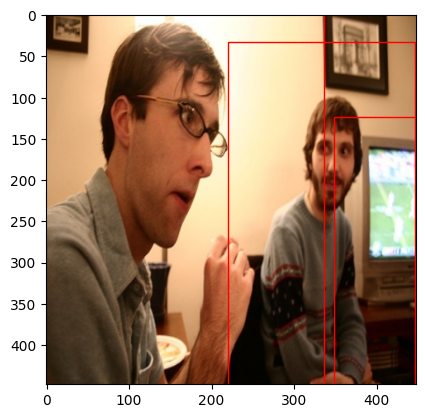

In [28]:
# plotting
bboxes = cellboxes_to_boxes(output)
bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
plot_image(image2.permute(1,2,0).to("cpu"), bboxes)

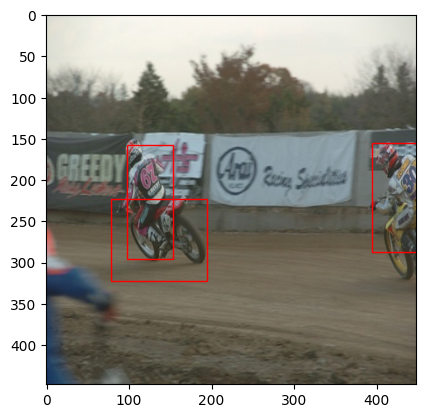

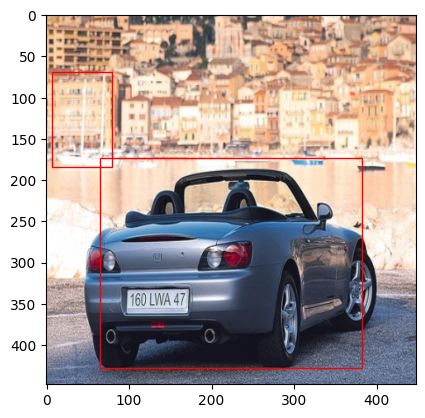

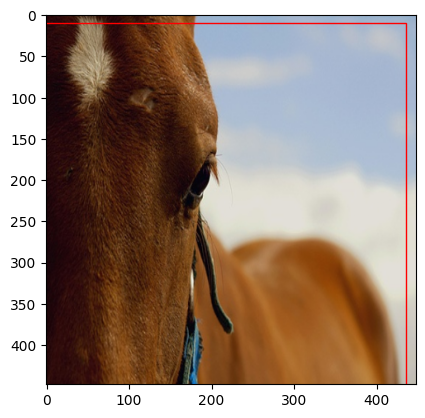

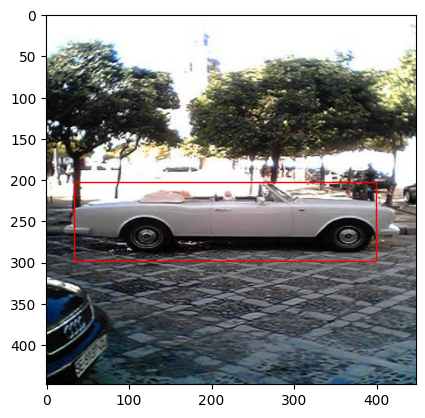

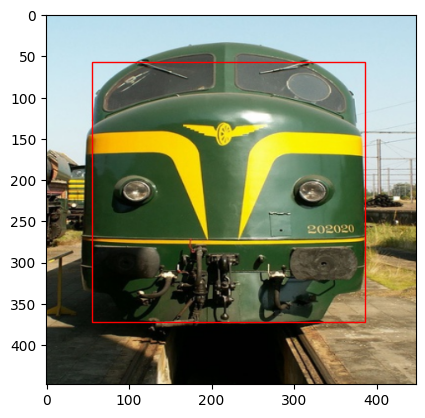

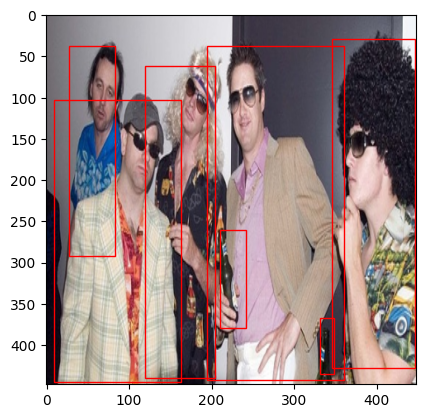

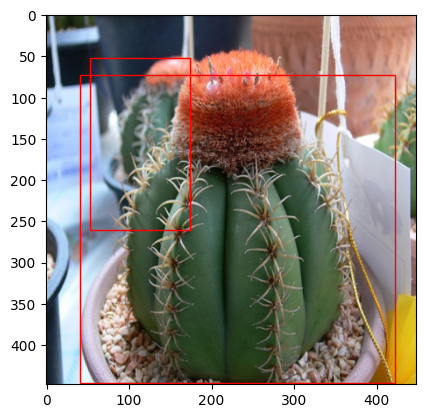

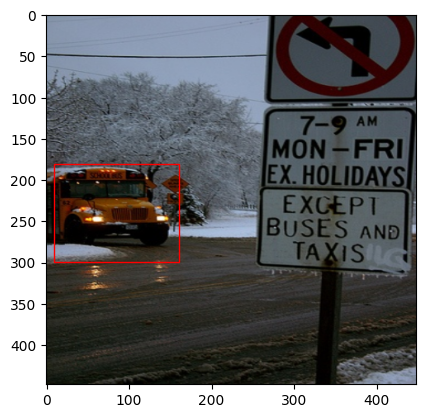

In [29]:
# Loop over a batch of data from the train_loader
for x, y in train_loader:
    x = x.to(DEVICE)  # Move the image batch to the device
    
    # Process each image in the batch (up to a batch size of 8)
    for idx in range(min(8, x.shape[0])):  # Ensure idx does not exceed batch size
        # Get the predicted bounding boxes from the model's output
        # Ensure the model's output is passed through the appropriate function
        predictions = model(x)  # Forward pass through the model
        bboxes = cellboxes_to_boxes(predictions)  # Convert model predictions to bounding boxes
        
        # Apply non-max suppression to remove duplicate boxes with low confidence
        # Here, we're selecting the boxes for the current image in the batch
        nms_boxes = non_max_suppression(
            bboxes[idx], 
            iou_threshold=0.5, 
            threshold=0.4, 
            box_format="midpoint"
        )
        
        # Plot the image and the detected bounding boxes
        # Permute the image to HWC format (from CHW format) for plotting
        plot_image(x[idx].permute(1, 2, 0).to("cpu"), nms_boxes)
    
    # Break after one batch to visualize the first few images
    break

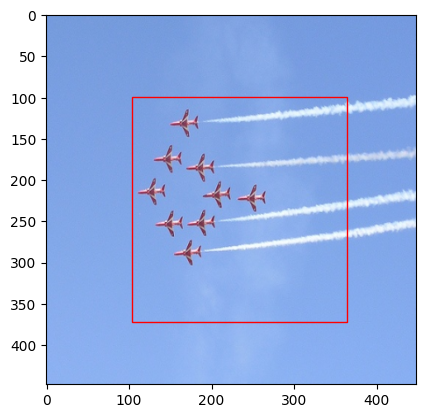

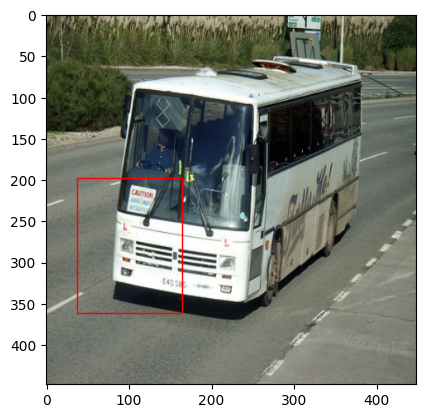

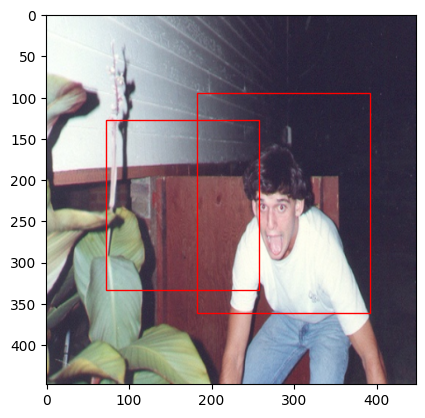

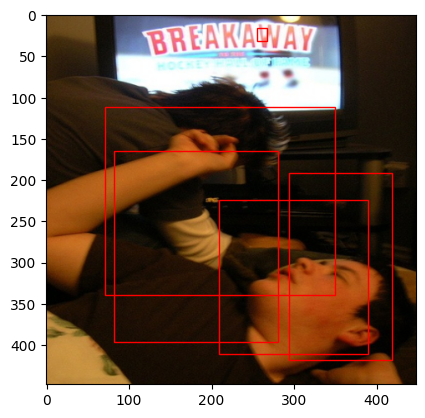

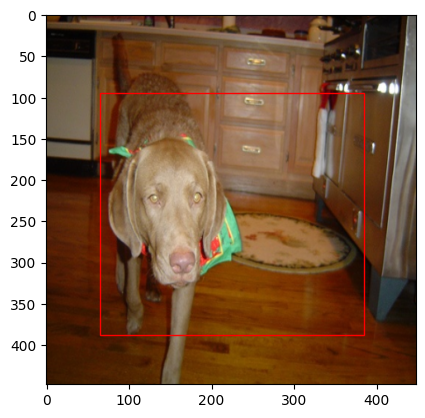

In [30]:
# Loop over a batch of data from the test_loader
for x, y in test_loader:
    x = x.to(DEVICE)  # Move the image batch to the device
    
    # Process the first 5 images in the batch (ensure batch size >= 5)
    for idx in range(min(5, x.shape[0])):  # Ensure idx does not exceed batch size
        # Get the predicted bounding boxes from the model's output
        predictions = model(x)  # Forward pass through the model
        bboxes = cellboxes_to_boxes(predictions)  # Convert model predictions to bounding boxes
        
        # Apply non-max suppression to remove duplicate boxes with low confidence
        nms_boxes = non_max_suppression(
            bboxes[idx], 
            iou_threshold=0.5, 
            threshold=0.4, 
            box_format="midpoint"
        )
        
        # Plot the image and the detected bounding boxes
        # Permute the image to HWC format (from CHW format) for plotting
        plot_image(x[idx].permute(1, 2, 0).to("cpu"), nms_boxes)
    
    # Break after processing one batch (for debugging/visualization)
    break


In [31]:
# Get the predicted and target bounding boxes for the entire test dataset
# The get_bboxes function should return predicted boxes and ground truth boxes
pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4)

# Calculate the mean average precision (mAP)
mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")

# Print the test mAP score
print(f"Test mAP: {mean_avg_prec}")

Test mAP: 0.0006638787453994155


In [32]:
# Get predicted and target bounding boxes for the training set
# The get_bboxes function processes each batch, applying thresholds and non-max suppression
pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

# Calculate the mean average precision (mAP) for the training set
# The mAP is a key evaluation metric for object detection, showing how well the model performs at detecting objects
mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")

# Print the mAP score for the training set
print(f"Train mAP: {mean_avg_prec}")

Train mAP: 0.9876887202262878
